<a href="https://colab.research.google.com/github/fyy26/Re-Summary/blob/main/522_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Imports
!pip install wget
!pip install transformers
!pip install wordcloud

import pandas as pd
import wget
import gzip
import sys
from tqdm import tqdm
import json
import os
import string
import re

from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f719f1f76c3db45ecdf3a915b6264ed8d05285361e21b633369368e47e700bb7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.7 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 29.4 MB/s 
     |████████████████████████████████| 6.6 MB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/n

In [ ]:
#@title Setting seed
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

In [ ]:
#@title Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Section 0: Instructions before running this colab file
Before running this colab file, make sure to run the colab file titled "Data and download prep" [(link)](https://colab.research.google.com/drive/1_5PJBkGUfNuyCGNW5n5F6CBmSSLgHhWb?usp=sharing). The "data and download prep" colab file downloads the original dataset and cleans/processes it into a new smaller file that we import in section 1 of this colab file.

#Section 1: Downloading pre-compiled pre-cleaned pandas dataframe

Connect to shared folder for data.*csv* file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Navigate to shared 522 project folder

In [ ]:
cd drive/Shareddrives/'522 Project'/'522 Project (Subfolder To Share)'

/content/drive/Shareddrives/522 Project/522 Project (Subfolder To Share)


In [ ]:
dfFilePath = "cleaned_data/136kreviews_starbalanced_df.csv"
df = pd.read_csv(dfFilePath)

For some reason, 2 na's get added back when we download the file, so remove them!

In [ ]:
#Make sure this has 136k rows
print("Shape: ", df.shape)
print("#Na's: ", df['reviewText'].isna().sum())
df.dropna(axis=0, subset=["reviewText"], inplace=True) #0 means to drop rows
print("#Na's after removing: ", df['reviewText'].isna().sum())

Shape:  (136530, 5)
#Na's:  2
#Na's after removing:  0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9384cbe50>]],
      dtype=object)

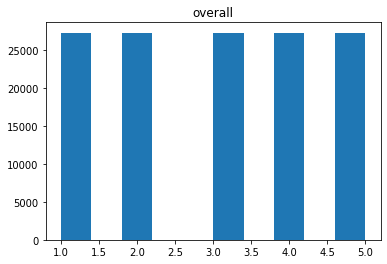

In [ ]:
#Make sure distribution of reviews is balanced
df.hist(column="overall", grid=False)

#Section 2: Initialize model to predict star ratings using review 
Code we consulted for finetuning BERT follows https://medium.com/analytics-vidhya/fine-tuning-bert-for-amazon-food-reviews-32e474de0e51 

Set config in one place to avoid hardcoded values throughout the project.

In [ ]:
config = {
  "splitRatio" : 0.8,
  "maxLength" : 100,
  "printEvery" : 200, #how many iterations of the training loop should you print model at
  "outputFolder" : "Models",
  "outputFileName" : "AmazonReviewClassifier.dat",
  "threads" : 2, #number of workers for dataloaders
  "batchSize" : 32, #16
  "validationFraction" : 0.1,  #the validationFraction param controls what fraction of the shuffled
          #validation set you want to validate the results on. should be as high as possible
  "epochs" : 2
}

Store path of project folder to save the best version of the model to. 

In [ ]:
projectFolder = "./"

In [ ]:
#@title Train and Val Split
def get_train_and_val_split(df, splitRatio=0.8):
    train = df.sample(frac=splitRatio, random_state=seed)
    val = df.drop(train.index)
    return(train, val)

In [ ]:
#@title DataLoader
class AmazonReviewsDataset(Dataset):
    def __init__(self, df, maxlen):
        """ Maxlen refers to how long a review can be.
            df must have columns: reviewText and overall """
        self.df = df

        # A reset reindexes from 1 to len(df), the shuffled df frames are sparse.
        self.df.reset_index(drop=True, inplace=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.maxlen = maxlen

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, index):
        review = self.df.loc[index, 'reviewText']

        # Classes start from 0.
        label = int(self.df.loc[index, 'overall']) - 1

        # Use BERT tokenizer since it needs to be able to match the tokens to the pre trained words.
        tokens = self.tokenizer.tokenize(review)

        # BERT inputs typically start with a '[CLS]' tag and end with a '[SEP]' tag. For
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        if len(tokens) < self.maxlen:
            # Add the ['PAD'] token
            tokens = tokens + ['[PAD]' for item in range(self.maxlen-len(tokens))]
        else:
            # Truncate the tokens at maxLen - 1 and add a '[SEP]' tag.
            tokens = tokens[:self.maxlen-1] + ['[SEP]']

        # BERT tokenizer converts the string tokens to their respective IDs.
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Converting to pytorch tensors.
        tokens_ids_tensor = torch.tensor(token_ids)

        # Masks place a 1 if token != PAD else a 0.
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [ ]:
#@title Classifier
class SentimentClassifier(nn.Module):
    def __init__(self, num_classes, device, freeze_bert = True):
        super(SentimentClassifier, self).__init__()
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        self.device = device

        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        self.dropout1 = nn.Dropout(0.2)
        self.res_squeeze1 = nn.Linear(768, 200)
        self.res_squeeze2 = nn.Linear(768, 20)

        self.cls_layer1 = nn.Linear(768, 300) #768: number of hidden units in the BERT model
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout()

        self.cls_layer2 = nn.Linear(300, 200) 
        self.dropout3 = nn.Dropout()

        self.cls_layer3 = nn.Linear(200, 20) 
        self.dropout4 = nn.Dropout()


        self.cls_layer4 = nn.Linear(20, num_classes)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''
        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks, return_dict=False)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        x1 = self.dropout1(cls_rep)
        x = self.cls_layer1(x1)
        x = self.relu(x)

        x2 = self.dropout2(x)
        x = self.cls_layer2(x2)
        x = self.relu(x)
        x = x + self.res_squeeze1(x1) # skip connection

        x3 = self.dropout3(x)
        x = self.cls_layer3(x3)
        x = self.relu(x)
        x = x + self.res_squeeze2(x1) # skip connection

        x4 = self.dropout4(x)

        x = self.cls_layer4(x4)

        #Feeding cls_rep to the classifier layer
        logits = x

        return logits.to(self.device)


In [ ]:
#@title Evaluation and Train Functions
def get_accuracy(logits, labels):
    # get the index of the max value in the row.
    predictedClass = logits.max(dim = 1)[1]

    # get accuracy by averaging over entire batch.
    acc = (predictedClass == labels).float().mean()
    return acc
    
def evaluate(net, loss_func, dataloader, config):
  net.eval()

  mean_acc, mean_loss = 0, 0
  count = 0

  m = nn.Softmax()
  with torch.no_grad():
      for seq, attn_masks, labels in dataloader:
          seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

          logits = net(seq, attn_masks)
          mean_loss += loss_func(m(logits), labels)
          mean_acc += get_accuracy(m(logits), labels)
          count += 1
          if count > config["validationFraction"] * len(dataloader):
              break
  print("    * Ran validation on " + str(count) + " batches")
  return mean_acc / count, mean_loss / count


def trainFunc(net, loss_func, opti, train_loader, test_loader, val_set, config):
    best_acc = 0
    m = nn.LogSoftmax(dim=1)

    for ep in range(config["epochs"]):
        print("\n\n")
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            if (it+1) % 1500 == 0:
              for group in opti.param_groups:
                group["lr"] = group["lr"] * 1e-1

            net.train()
            opti.zero_grad()
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            logits = net.forward(seq, attn_masks)
            loss = loss_func(m(logits), labels)

            loss.backward()
            opti.step()

            if (it + 1) % config["printEvery"] == 0: #Test on a small sample of the val_data every x epochs
                print("Iteration {} of epoch {} complete. ".format(it+1, ep+1))
                acc = get_accuracy(m(logits), labels)
                print(" - Training Loss : {} Accuracy : {}".format(loss.item(), acc))
                #instantiate a new dataloader in order to shuffle the data and validate on a different sample than last time
                val_loader = DataLoader(val_set, batch_size = config["batchSize"], num_workers = config["threads"], shuffle=True)
                val_acc, val_loss = evaluate(net, loss_func, val_loader, config)
                print(" - Validation Loss : {} Accuracy : {}".format(val_loss, val_acc))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Split df into train and validation with 95/5 split. 

In [ ]:
train, val = get_train_and_val_split(df, splitRatio=config["splitRatio"])

Create and initialize dataloader to feed reviews into BERT, which only takes in lowercased text and specialized tokens. 

In [ ]:
train_set = AmazonReviewsDataset(train, config["maxLength"])
val_set = AmazonReviewsDataset(val, config["maxLength"])

train_loader = DataLoader(train_set, batch_size = config["batchSize"], num_workers = config["threads"])
val_loader = DataLoader(val_set, batch_size = config["batchSize"], num_workers = config["threads"], shuffle=True)

For classification (using SentimentClassifier), we feed a sequence of token ids (representing sentences) to the pre-trained Bert Model. Since the [CLS] token represents the sentence-level embedding, we can capture the [CLS] token from the BERT layer and feed it into a linear layer. The last linear layer outputs 5 numbers, which represent each rating. 

In [ ]:
num_classes = df['overall'].nunique()
net = SentimentClassifier(num_classes, device, freeze_bert=False)
net.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

Set our loss function as negative loss likelihood.

In [ ]:
loss_func = nn.NLLLoss()

Use Adam optimizer with small learning rate

In [ ]:
opti = optim.Adam(net.parameters(), lr = 2e-5)

Make sure we are using the right device: output should be 'cuda'

In [ ]:
device

device(type='cuda')

Run it!

#Section 3: Train the model!
This section takes ~45 minutes on colab (not pro). You can skip this section and jump directly to section 4 in order to load our pre-trained model from section 3a.

In [ ]:
trainFunc(net, loss_func, opti, train_loader, val_loader, val_set, config)




Iteration 200 of epoch 1 complete. 
 - Training Loss : 1.1300878524780273 Accuracy : 0.40625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


    * Ran validation on 86 batches
 - Validation Loss : -0.4146600365638733 Accuracy : 0.5646802186965942
Iteration 400 of epoch 1 complete. 
 - Training Loss : 1.1280219554901123 Accuracy : 0.5625
    * Ran validation on 86 batches
 - Validation Loss : -0.4523603320121765 Accuracy : 0.5777616500854492
Iteration 600 of epoch 1 complete. 
 - Training Loss : 1.2182890176773071 Accuracy : 0.4375
    * Ran validation on 86 batches
 - Validation Loss : -0.48547056317329407 Accuracy : 0.601017415523529
Iteration 800 of epoch 1 complete. 
 - Training Loss : 0.9335944652557373 Accuracy : 0.5625
    * Ran validation on 86 batches
 - Validation Loss : -0.4898546636104584 Accuracy : 0.604651153087616
Iteration 1000 of epoch 1 complete. 
 - Training Loss : 0.8852460980415344 Accuracy : 0.65625
    * Ran validation on 86 batches
 - Validation Loss : -0.4953274428844452 Accuracy : 0.6104651093482971
Iteration 1200 of epoch 1 complete. 
 - Training Loss : 0.8305493593215942 Accuracy : 0.625
    * Ran

In [ ]:
#test the model!
originalValFraction = config['validationFraction']
config['validationFraction'] = 1.0
val_acc, val_loss = evaluate(net, loss_func, val_loader, config)
config['validationFraction'] = originalValFraction

print(" Validation Accuracy : {}, Validation Loss : {}".format(val_acc, val_loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


    * Ran validation on 854 batches
 Validation Accuracy : 0.627166211605072, Validation Loss : -0.5296758413314819


When we ran this model locally for 5 epochs, the model achieved 65% validation accuracy. We could not replicate the results on Google Colab, because Colab did not have as much computational power as our local machine.

We will still save the model for demonstration purposes, but in the next section we will load the model that we trained locally for longer. 


In [ ]:
#Save the model!
torch.save(net, os.path.join(projectFolder, config["outputFolder"], config["outputFileName"] + "_unbiased_valTested_" + str(val_acc)))

#Section 4: Loading model and testing on all validation data
The reason we save the model in section 3 and load the model in section 4 is so that we do not have to retrain the model every time we close and open Google colab. Since training takes ~45 minutes, loading saves us a lot of time.

In [ ]:
#Load the model - uncomment this later.
net = torch.load("Models/residual_2epochs_65val").to(device)

In [ ]:
#Test model on 10% validation
originalValFraction = config['validationFraction']
config['validationFraction'] = 0.1
val_acc, val_loss = evaluate(net, loss_func, val_loader, config)
config['validationFraction'] = originalValFraction

print(" Validation Accuracy : {}, Validation Loss : {}".format(val_acc, val_loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


    * Ran validation on 86 batches
 Validation Accuracy : 0.6362645030021667, Validation Loss : -0.5378854274749756


Running this model on 10% of the validation data yields 63.6% validation accuracy, which is close to the 65% validation accuracy we got from testing this model on 100% of the validation data locally. Running hte validation on all 100% of the data via colab takes too long, so that is why we decided to only validate on 10% after loading as a sanity check.

#Section 5: Running model on sample reviews

Add a predict function to allow us to play with fake reviews.

In [ ]:
def predict(net, reviewTexts):
  """This function feeds an array of review texts into the net and returns a corresponding set of ratings"""
  """needs config to work"""
  predict_data = [[-1000, '', reviewText, ''] for reviewText in reviewTexts]
  predict_df = pd.DataFrame(predict_data, columns = ['overall', 'asin', 'reviewText', 'summary'])
  predict_set = AmazonReviewsDataset(predict_df, config["maxLength"])
  predict_loader = DataLoader(predict_set, batch_size = config["batchSize"], num_workers = config["threads"])
  
  predictions_by_batch = []
  for batch in predict_loader:
    seq, attn_masks, _ = batch
    seq, attn_masks = seq.to(device), attn_masks.to(device)
    logits = net.forward(seq, attn_masks)
    softmaxed = nn.LogSoftmax(dim=1)(logits)
    batch_predictions = torch.argmax(softmaxed, dim=1) + 1 #we subtract 1 in the training, so add 1 back now.
    predictions_by_batch.extend(batch_predictions)
  return predictions_by_batch

In [ ]:
print(predict(net, ["They look durable", 
                    "They look bad.",
                    "They look adorable.",
                    "They look dirty"]))

#Following reviews are from amazon: https://www.amazon.com/product-reviews/B09WHL1T6L/ref=cm_cr_arp_d_viewopt_srt?ie=UTF8&filterByStar=four_star&reviewerType=all_reviews&pageNumber=1&sortBy=recent#reviews-filter-bar
#these reviews are unseen by our model!

#expected: 2 stars
print(predict(net, ["Cheap and unimpressive. Maybe I missed it, but I was surprised to see this was totally unlined. I'm sure it's waterproof, but so is a $1 poncho from the gas station. If you care about it being a name-brand, then this is for you. If you're more concerned with functionality, look elsewhere.",
                    "I was a little shocked to see a Columbia jacket so flimsy. No lining and it's made out of a lightweight nylon. The child will definitely need a sweater under it. So disappointed.",
                    'For this to be a rain jacket, this PAPER thin. Its ridiculously thin. I was so amazed at how thin it was when I got it in the mail. And the sizing was off a little. My son usually wears a 12 but I would have to size up in this "jacket"',
                    "Meh. This thing is more like a wind breaker than a rain coat. We didn’t end up using it because I think it felt more like a disposal poncho. There’s no lining in it whatsoever. Not a fan, I’m sending it back."]))

#expected 4 stars
print(predict(net, ["This jacket is fully waterproof but doesn’t have a drawstring for the hood. It’s a great, lightweight, unlined rain jacket that can be layered in colder weather. I got size 2T for a 15 month old child who is 32” tall and weighs 25 lbs. although the hood doesn’t have a drawstring, it’s large enough and it stays on his head just fine. I was looking for elastic wrists and this has them, although it is big on him so they don’t work as planned. He’s pictured wearing a Mickey Mouse harness and a drool bib over the jacket.",
                    "Perfect spring/fall waterproof toddler jacket! Our family loves Columbia so it was only fitting for our little man to have one of his own. He’s 16 months, and 27 lbs- wears 24months/2T in tops so I ordered the 2T so he’d have some growing and it’s a little big for now which I’m happy with! It doesn’t have any internal layer which will make it a good jacket for summer rain on camp trips too!",
                    "This review is for the size. My son is 12, bought a Large for him but it's way to big. It seems the size of this one is different from the black one which fits a 11 year old boy per another review. I am 5'5 and it's even too big for me. The quality of the jacket is great though. Will exchange for a black one to see if it fits.",
                    "This jacket is super cute on my son. It’s not really a warm jacket, more of a windbreaker. The only flaw I have found is you have to put the hood on before you zip it all the way up."]))

[tensor(4, device='cuda:0'), tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(2, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0')]
[tensor(3, device='cuda:0'), tensor(5, device='cuda:0'), tensor(3, device='cuda:0'), tensor(4, device='cuda:0')]


In [ ]:
print(predict(net, ["This is great"]))
print(predict(net, ["The pasta is bad", "The pasta is bad but looks cool"]))

[tensor(5, device='cuda:0')]
[tensor(2, device='cuda:0'), tensor(3, device='cuda:0')]


We can see the model performs pretty well on these out-of-sample reviews that we found from Amazon! This is more of a sanity check though, because we already did validation in the previous step, which is a more robust method for testing our model out-of-sample. 

# Section 6: Part of Speech Tagging and Masking Adjectives
Here, we tag adjectives in the reviews, and mask the adjectives for each review, one adjective at a time.


We consulted https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/ to help with this section. 

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
stop_words = set(stopwords.words('english'))

In [ ]:
tags_of_interest = ['JJ', # adjective – ‘big’
                    'JJR', # adjective, comparative – ‘bigger’ 
                    'JJS', # adjective, superlative – ‘biggest’
                    ]
mask_word = '[MASK]' # the BERT mask token

```masked_reviews``` is a list of tuples ```(review_original, [(adjective1, review_masked), (adjective2, review_masked)], ...)```
Takes < 3 min
Note: if an adjective occurs multiple times, all occurrences are masked.

In [ ]:
masked_reviews = []
i = 0
for index, row in df.iterrows():
  if i % 10000 == 0:
    print('{:.2f}'.format(i / df.shape[0] * 100), '% complete', sep='')
  review = row['reviewText']
  tokens = tokenizer.tokenize(review)
  word_list = [w for w in tokens if not w in string.punctuation] # filter out punctuation
  word_list = [w for w in word_list if not w.startswith('##')] # filter out suffix tokens
  word_list = [w for w in word_list if not w in stop_words] # filter out stop words
  tagged = nltk.pos_tag(word_list) # apply POS tagger
  candidate_words = set(w for w, tag in tagged if tag in tags_of_interest)
  masked_reviews.append(tuple((review, [tuple((w, re.compile(re.escape(w), re.IGNORECASE).sub(mask_word, review))) for w in candidate_words])))
  i += 1

0.00% complete
7.32% complete
14.65% complete
21.97% complete
29.30% complete
36.62% complete
43.95% complete
51.27% complete
58.60% complete
65.92% complete
73.25% complete
80.57% complete
87.89% complete
95.22% complete


In [ ]:
# View the first 10 masked reviews
masked_reviews[:10]

[('Just kind of a nothing little story. Not awful, but not great.',
  [('little',
    'Just kind of a nothing [MASK] story. Not awful, but not great.'),
   ('great',
    'Just kind of a nothing little story. Not awful, but not [MASK].'),
   ('awful',
    'Just kind of a nothing little story. Not [MASK], but not great.')]),
 ('Smells very nice.', [('nice', 'Smells very [MASK].')]),
 ("Doesn't stay longer than 4-5 days ,bad quality.",
  [('bad', "Doesn't stay longer than 4-5 days ,[MASK] quality.")]),
 ('very cheap & not a good color, looks cheap & comes off easily. . . . . . . .',
  [('good',
    'very cheap & not a [MASK] color, looks cheap & comes off easily. . . . . . . .'),
   ('cheap',
    'very [MASK] & not a good color, looks [MASK] & comes off easily. . . . . . . .')]),
 ('Dirty and sandy. Not a fan.', [('dirty', '[MASK] and sandy. Not a fan.')]),
 ('works well for my needs', []),
 ("I'll take your word that it fits 99% of the brush cutters, but it DIDN'T fit my Homelite.",
  []

In [ ]:
# Check if any candidate word failed to be masked
# Print any failed words; if empty output, all success
for review, masks in masked_reviews:
  for word, masked_review in masks:
    if not mask_word in masked_review:
      print(review)
      print(word)

#Section 7: Evaluate Candidate Adjectives

In this section, we create dictionary `adjs_pred` that stores (`adj`, `predictivenesses`), where `predictivenesses` is an array of numbers, each of which can range from 0-4. We will later take an average of this array to get one `predictiveness` value for each adjective.

For each masked review (following is pseudo code):
1. `original_rating` = Calculate rating of original review using `net`
2. `masked_rating` = Calculate rating of masked review using `net`
3. `pred = abs(original_rating - masked_rating)`
4. 
```
if adj in adjs_pred.keys():
      adjs_pred[adj].append(pred)
else:  
      adjs_pred[adj] = [pred]
```



In the code section below, we implement steps 1-2, where we run the masked/original reviews through our net in order to find how many stars each masked/original review should get. The output of getOriginalStars is of the format [original_score] and the output of getMaskedStars is of the format [[(adj, masked_score)]]. The reason that getMaskedStars is a two-dimensional array whereas getOriginalStars is a one-dimensional array is that for each review, there are multiple adjectives, and so for each review there are multiple masked reviews that can be generated.

(Change review_limit below to control the number of reviews we process, as this algorithm takes a long time to run).

In [ ]:
def getOriginalStars(net, masked_reviews, device, review_limit):
  #Masked_reviews format is [(originalReview, [(adj, maskedReview)])]
  reviewTexts = [review for review, masks in masked_reviews]
  predict_data = [[-1000, '', reviewText, ''] for reviewText in reviewTexts]
  predict_df = pd.DataFrame(predict_data, columns = ['overall', 'asin', 'reviewText', 'summary'])

  predict_set = AmazonReviewsDataset(predict_df, config["maxLength"])
  predict_loader = DataLoader(predict_set, batch_size = config["batchSize"], num_workers = config["threads"])

  original_scores = None

  for i, batch in enumerate(predict_loader):
    if i == (review_limit/config["batchSize"]):
      return original_scores

    seq, attn_masks, _ = batch
    seq, attn_masks = seq.to(device), attn_masks.to(device)
    logits = net.forward(seq, attn_masks)
    softmaxed = nn.LogSoftmax(dim=1)(logits)
    
    if original_scores != None:
      new_scores = torch.argmax(softmaxed, dim=1) + 1
      original_scores = torch.cat([original_scores, new_scores], axis=0)
    else:
      original_scores = torch.argmax(softmaxed, dim=1) + 1

  return original_scores

def getMaskedStars(net, masked_reviews, device, review_limit):
    masked_reviews = masked_reviews[:review_limit]
    #limit masked_reviews to batch size
    review_to_adj_star_tuples = [] 
    #Masked_reviews format is [(originalReview, [(adj, maskedReview)])]
    masked_reviews_only = [] 
    #flatten masked_reviews and pull the "maskedReview" into the masked_reviews_only array
    num_adjs = 0
    for i, (review, masks) in enumerate(masked_reviews):
      for (adj, masked_review) in masks:
        masked_reviews_only.append(masked_review)
        num_adjs += 1
    masked_reviews_only_predictions = predict(net, masked_reviews_only)

    #now fill up review_to_adj_star_tuples based on the masked_reviews_only_predictions
    count = 0
    for i, (review, masks) in enumerate(masked_reviews):
      adj_to_rating_tuples = []
      for (adj, masked_review) in masks:
        score_for_adj = masked_reviews_only_predictions[count]
        count += 1
        adj_to_rating_tuples.append((adj, score_for_adj))
      review_to_adj_star_tuples.append(adj_to_rating_tuples)

    return review_to_adj_star_tuples   
    
config["batchSize"] = 32 #can make this anything, but not too high since CPU will crash
review_limit = 100 * config["batchSize"] # number of reviews to run through (!!!! must be a multiple of batchSize)
original_scores = getOriginalStars(net, masked_reviews, device, review_limit)
masked_scores = getMaskedStars(net, masked_reviews, device, review_limit)

Now that we have completed, steps 1-2 we can do steps 3-4, which consists of comparing the masked scores to original scores to determine how predictive each adjective is. We store this predictiveness in the dictionary adjs_pred as we have already outlined above. As stated above, the dictionary adjs_pred stores (adj, predictivenesses) as the (key, value), where predictivenesses is an array of numbers, each of which can range from 0-4. Each predictiveness value for an adjective corresponds to a different review in which that adjective was masked. We will later take an average of this array to get one predictiveness value for each adjective.

In [ ]:
adjs_pred = {} 
for i, original_score in enumerate(original_scores):
  for (adj, masked_score) in masked_scores[i]:
    predictiveness = abs(masked_score - original_score)
    if adj in adjs_pred.keys():
      adjs_pred[adj].append(predictiveness.item())
    else:
      adjs_pred[adj] = [predictiveness.item()]
        
adjs_pred

{'4th': [0],
 'able': [0, 0, 0, 0, 0, 0],
 'absolute': [0],
 'acceptable': [0],
 'accurate': [0, 0, 0, 0, 0, 0],
 'acidic': [0],
 'actual': [0, 0],
 'adapt': [0],
 'add': [0, 0, 0],
 'adi': [0],
 'adjust': [0],
 'adjustable': [0],
 'adorable': [0, 1, 0],
 'advanced': [0],
 'advertised': [0, 0, 0, 1],
 'afghan': [0],
 'afraid': [0],
 'al': [0],
 'album': [0, 1],
 'alex': [0],
 'ali': [0],
 'align': [0],
 'alive': [0, 0],
 'allow': [0],
 'alternative': [1],
 'amazing': [0, 0],
 'amazon': [0],
 'angel': [0],
 'ant': [0],
 'anti': [0],
 'apart': [0],
 'app': [0],
 'applicable': [0],
 'applied': [0],
 'appreciated': [0],
 'appropriate': [1, 0],
 'arrival': [1],
 'arrive': [0, 0, 0],
 'arrived': [0, 0, 0, 0],
 'artificial': [0],
 'artistic': [1, 0],
 'assemble': [0, 0],
 'ate': [0, 0, 1],
 'atlantic': [0],
 'attempt': [1],
 'attractive': [0],
 'atv': [0],
 'aubrey': [1],
 'australian': [0],
 'authentic': [0],
 'automotive': [0],
 'available': [0, 0],
 'average': [0, 0, 0],
 'aw': [0],
 'awar

#Section 8: Clean and view predictive adjectives 

For each value in the dictionary adj_pred, set the value equal to the average of the array, because right now, each adjective has multiple predictiveness values (one for each time it appears in a reivew). Also, remove adjectives that have a predictiveness of 0. Call the new dictionary adj_impacts.

In [ ]:
adj_impacts = {}
for key in adjs_pred.keys():
  mini_lists = adjs_pred[key]
  total = len(mini_lists)
  summed_diffs = sum([l for l in mini_lists])
  if summed_diffs != 0:
    adj_impacts[key] = summed_diffs/total

Let's check how many non-zero predictive adjectives we found:

In [ ]:
len(adj_impacts)

231

Now let's sort the adjective impacts!

In [ ]:
sorted(adj_impacts.items(), key=lambda item: item[1], reverse=True)

[('ineffective', 4.0),
 ('floppy', 3.0),
 ('suck', 2.0),
 ('hi', 2.0),
 ('novel', 2.0),
 ('dvd', 2.0),
 ('pen', 2.0),
 ('tangle', 2.0),
 ('mp', 2.0),
 ('salt', 2.0),
 ('awful', 1.5),
 ('dumb', 1.5),
 ('sad', 1.4),
 ('soo', 1.0),
 ('text', 1.0),
 ('knife', 1.0),
 ('ji', 1.0),
 ('todd', 1.0),
 ('grey', 1.0),
 ('terrific', 1.0),
 ('arrival', 1.0),
 ('bob', 1.0),
 ('pictured', 1.0),
 ('glad', 1.0),
 ('dusty', 1.0),
 ('pup', 1.0),
 ('nissan', 1.0),
 ('notice', 1.0),
 ('classic', 1.0),
 ('hum', 1.0),
 ('lightweight', 1.0),
 ('degree', 1.0),
 ('split', 1.0),
 ('involved', 1.0),
 ('start', 1.0),
 ('robinson', 1.0),
 ('delicate', 1.0),
 ('alternative', 1.0),
 ('functional', 1.0),
 ('wr', 1.0),
 ('warren', 1.0),
 ('hole', 1.0),
 ('attempt', 1.0),
 ('foot', 1.0),
 ('burnt', 1.0),
 ('pick', 1.0),
 ('rushed', 1.0),
 ('gigantic', 1.0),
 ('lowest', 1.0),
 ('squeeze', 1.0),
 ('brown', 1.0),
 ('easiest', 1.0),
 ('est', 1.0),
 ('sour', 1.0),
 ('promised', 1.0),
 ('scale', 1.0),
 ('oct', 1.0),
 ('update'

#Section 9: Generate Summary Word Cloud

https://www.tutorialexample.com/python-create-word-cloud-image-by-word-frequency-or-weight-value-python-wordcloud-tutorial/

First, let's aggregate each product's reviews and join them into one bigger review to make the following steps for creating a word cloud easier. Let's also find the products with the most amount of reviews to generate "fluffy" word clouds.

In [ ]:
df_by_product = df.groupby(['asin'])['reviewText'].apply(' , '.join).reset_index()
sorted_by_review_length = df_by_product.reviewText.str.len().sort_values().index
#Let's print the asins of the products iwth the most reviews (in terms of string length)
print (df_by_product.reindex(sorted_by_review_length).tail(10))
#the following asins have a lot of product reviews
yarn_asin = "B0001DUD9O"
hobbit_book_asin = "000711835X"
converse_shoe_asin = "B00006XXGO"


             asin                                         reviewText
20093  B000XZY8H8  great yarn at a great price, highly recommend ...
13864  B000BY4Q5K  This yarn is so soft and really holds up well ...
569    0007155662  Paulo Coelho gets the point across, in a quick...
11868  B000980L02  Caps are a little harder than I expected but s...
534    0007141424  Order and chaos\nWrapped up in a short novel\n...
11634  B0007YR980  Not appropiate for small woman! , 3 stars beca...
6034   B00006XXGO  More like a size 12 , Very good I still got a ...
478    000711835X  Sometimes I dozed off but its a really great s...
7865   B0001YRFS0  Needs to be more true to size.  They are a goo...
7679   B0001DUD9O  great price for the yarn. I can make at least ...


Now let's create a method that generates a word cloud based on the most useful adjectives that pertain to a product's reviews. In order to calculate usefulness of an adjective for a product, we multiply the predictiveness^2 of that adjective with the amount of times that the adjective appears across all the product's reviews. 

In [ ]:
def computeWordCloud(asin):
  all_reviews_str = "" #a variable to store all the review text aggregated together for 1 product
  for index, row in df_by_product.iterrows():
    if row["asin"] == asin:
      all_reviews_str = row["reviewText"]
      break
  review_text_tokens = tokenizer.tokenize(all_reviews_str)
  useful_adjs = {} #stores  (adj, (predictiveness, count))
  #for each adjective that appears in the reviews, 
  for token in review_text_tokens:
    for adj, pred in adj_impacts.items():
      if token == adj:
        (_, count) = useful_adjs.get(adj, (0, 0)) #(0, 0) gets returned if the adj is not found
        useful_adjs[adj] = (pred, count + 1)
        break #because none of the remaining adjectives can possibly match the token

  #compute usefulness values by multiplying predictiveness with count
  cleaned_useful_adjs = {} #array of tuples: [(adj, usefulness)]
  for adj, (pred, count) in useful_adjs.items():\
    cleaned_useful_adjs[adj] = (pred**2) * count

  #now create word clouds from top 20 useful words
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  min_font_size = 10)
  wordcloud.fit_words(cleaned_useful_adjs)
  return wordcloud

metallica_cd_asin = "B000002H33"
metallica_cd_wc = computeWordCloud(metallica_cd_asin)


Display the word clouds!

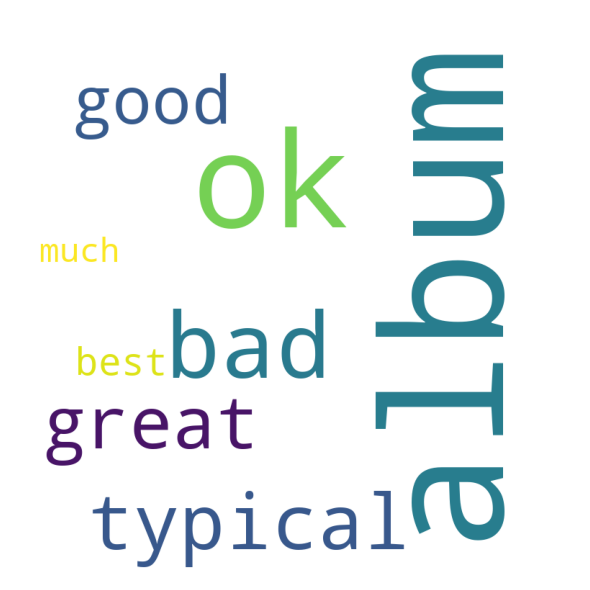

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(metallica_cd_wc)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Now let's try for products with more reviews in it

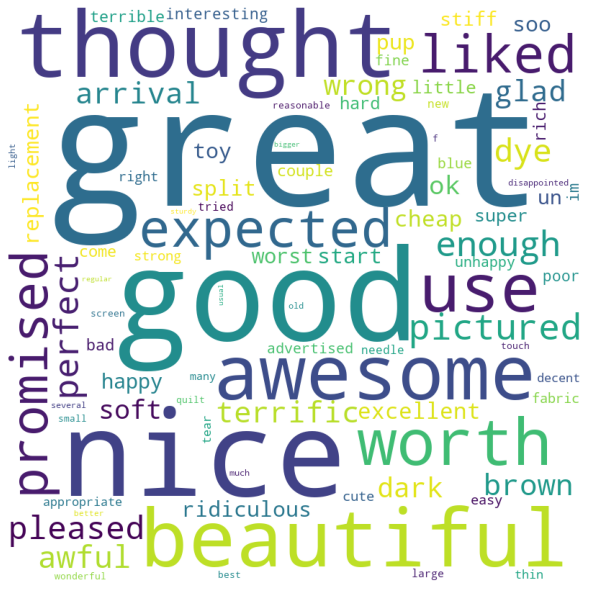

In [ ]:
yarn_wc = computeWordCloud(yarn_asin)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(yarn_wc)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

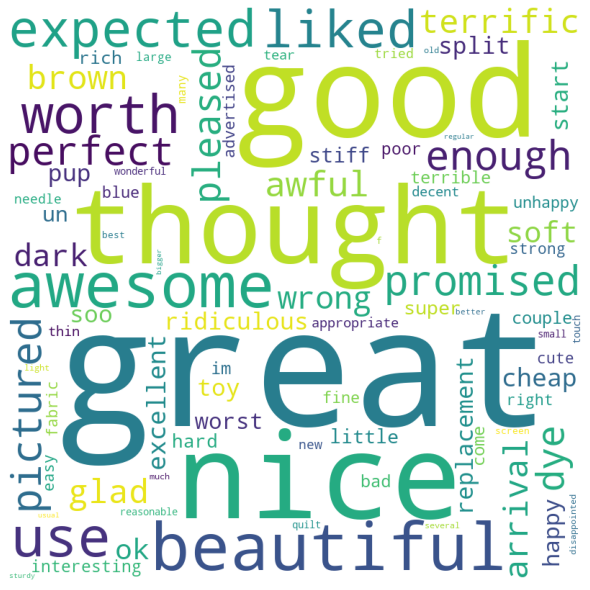

In [ ]:
converse_shoe_wc = computeWordCloud(yarn_asin)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(converse_shoe_wc)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

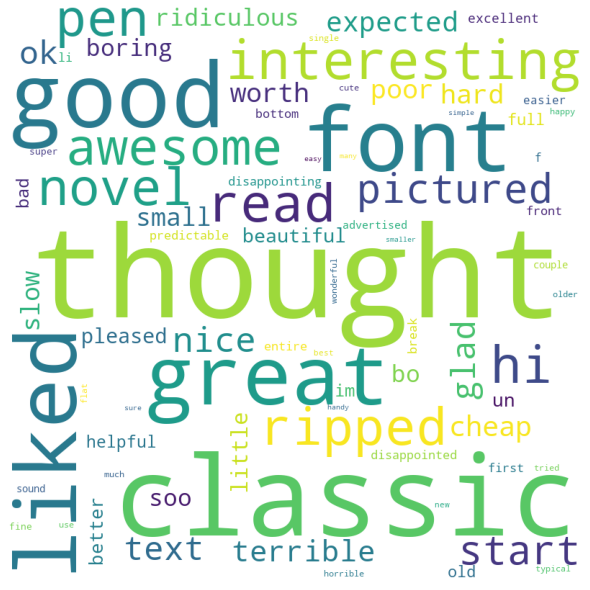

In [ ]:
hobbit_book_asin = "000711835X"
hobbit_book_wc = computeWordCloud(hobbit_book_asin)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(hobbit_book_wc)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()